In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path) 

Mounted at /content/drive


#Importing pre-requisites


In [ ]:
import numpy as np
import torch
import torch_geometric.data as data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import knn_graph
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, ModuleList
from torch_geometric.nn import MetaLayer, global_add_pool, global_mean_pool, global_max_pool, LayerNorm, MessagePassing
from torch_scatter import scatter_mean, scatter_add, scatter_max

#Making the dataset

In [ ]:
class make_dataset(Dataset):
    def __init__(self, n_graphs, n_nodes, n_connects, mode, verbose=True):
        super().__init__()

        if verbose:
            print('Creating {} dataset...'.format(mode))

        #forming different random seed values for each graph
        seed_list = []
        for i in range(n_graphs):
            seed_list.append(i)

        #initialising list to append all graphs
        graphs = []

        all_pos = []
        all_cm_x = []
        all_cm_y = []
        all_cm_z = []
        all_nodes = []
        all_edges = []
        all_edge_attr = []

        for i in range(n_graphs):

            #defining number of nodes and seed value
            seed = seed_list[i]
            np.random.seed(seed)

            #defining the node features : masses
            node_features = torch.zeros((n_nodes,4), dtype = torch.float32)
            masses = torch.as_tensor(np.random.rand(n_nodes), dtype = torch.float32)
            node_features[:,0] = masses

            #positions in 3D
            node_pos = torch.zeros((n_nodes,3), dtype = torch.float32)
            for i in range(n_nodes):
                pos = torch.as_tensor([np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)], dtype = torch.float32)
                node_pos[i,:] = pos
                node_features[i,1] = pos[0]
                node_features[i,2] = pos[1]
                node_features[i,3] = pos[2]
            all_pos.append(node_pos)            
            all_nodes.append(node_features)

            #defining the edge connections
            edges = knn_graph(node_pos, k=n_connects, loop=False, num_workers=1)
            all_edges.append(edges)

            #setting the edge length as edge attributes
            row, col = edges
            pos_row = node_pos[row].numpy()
            pos_col = node_pos[col].numpy()
            edge_attr = torch.zeros([len(row),1], dtype = torch.float32)
            for i in range(len(row)):
                dist = torch.as_tensor(np.linalg.norm(pos_row[i] - pos_col[i]), dtype = torch.float32)
                edge_attr[i,:] = dist
            all_edge_attr.append(edge_attr)


            #cahculating the centre of mass in 3D and subtracting from the coordinates of the centre of box (0.5)

            xval = node_pos[:,0]
            yval = node_pos[:,1]
            zval = node_pos[:,2]

            #finding the distance between the centre of mass and the centre of the box
            cm_x = (torch.sum(torch.multiply(xval,masses))/torch.sum(masses)) - 0.5
            cm_y = (torch.sum(torch.multiply(yval,masses))/torch.sum(masses)) - 0.5
            cm_z = (torch.sum(torch.multiply(zval,masses))/torch.sum(masses)) - 0.5

            all_cm_x.append(cm_x)
            all_cm_y.append(cm_y)
            all_cm_z.append(cm_z)


        #normalising the values in x, y and z coordinates

        all_cm_x = np.asarray(all_cm_x)
        all_cm_y = np.asarray(all_cm_y)
        all_cm_z = np.asarray(all_cm_z)

    
        self.mean_x = np.mean(all_cm_x)
        self.mean_y = np.mean(all_cm_y)
        self.mean_z = np.mean(all_cm_z)

        self.std_x = np.std(all_cm_x)
        self.std_y = np.std(all_cm_y)
        self.std_z = np.std(all_cm_z)

        all_cm_x = (all_cm_x-self.mean_x)/(self.std_x)
        all_cm_y = (all_cm_y-self.mean_y)/(self.std_y)
        all_cm_z = (all_cm_z-self.mean_z)/(self.std_z)


        #initialising final list of labels
        labels_list = []

        for i in range(n_graphs):

            x = all_nodes[i]
            pos = all_pos[i]
            edges = all_edges[i]
            edge_attr = all_edge_attr[i]

            cm_x = all_cm_x[i]
            cm_y = all_cm_y[i]
            cm_z = all_cm_z[i]

            y = torch.zeros((3), dtype = torch.float32)
            y[:] = torch.as_tensor([cm_x, cm_y, cm_z], dtype = torch.float32)
            labels_list.append(y)

            #loading these tensors into a PyG graph and appending them to the graphs list
            graph = data.Data(x = x, edge_index = edges, edge_attr = edge_attr, pos = pos)
            graphs.append(graph)

        if   mode=='train':  offset, size_graphs = int(0.00*n_graphs), int(0.90*n_graphs)
        elif mode=='valid':  offset, size_graphs = int(0.90*n_graphs), int(0.05*n_graphs)
        elif mode=='test':   offset, size_graphs = int(0.95*n_graphs), int(0.05*n_graphs)
        elif mode=='all':    offset, size_graphs = int(0.00*n_graphs), int(1.00*n_graphs)
        else:                raise Exception('Wrong name!')

        self.graphs = graphs[offset:offset+size_graphs]
        self.size = size_graphs
        self.labels = labels_list[offset:offset+size_graphs]


    def norm_params(self):
        return self.mean_x, self.mean_y, self.mean_z, self.std_x, self.std_y, self.std_z


    def __len__(self):
        return self.size
        del self.size


    def __getitem__(self, idx):

        return self.graphs[idx], self.labels[idx]
        del self.graphs[idx], self.labels[idx]


def create_dataloader(mode, n_graphs, n_nodes, n_connects, batch_size, shuffle=True, verbose=False):
    
    data_set = make_dataset(n_graphs, n_nodes, n_connects, mode, verbose = True)
    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)


    mean_x, mean_y, mean_z, std_x, std_y, std_z = data_set.norm_params()

    if verbose:
        print('{} dataset created!\n'.format(mode))

    return data_loader, mean_x, mean_y, mean_z, std_x, std_y, std_z


#Creating Training and Validation DataLoaders

In [ ]:
n_graphs = 2000
n_nodes = 100
n_connects = 10
batch_size = 128

import time

start = time.time()

train_dl, mean_x, mean_y, mean_z, std_x, std_y, std_z = create_dataloader('train', n_graphs, n_nodes, n_connects, batch_size, verbose = True)
valid_dl, mean_x, mean_y, mean_z, std_x, std_y, std_z = create_dataloader('valid', n_graphs, n_nodes, n_connects, batch_size, verbose = True)
#test_dl = create_dataloader('test', n_graphs, n_nodes, n_connects, batch_size, verbose = True)

stop = time.time()

print('\nTime taken to create training, validation and test datasets: ', (stop-start)/3600.0)


Creating train dataset...
train dataset created!


Time taken to create training, validation and test datasets:  0.012880651619699266


#Using GPU if availabe

In [ ]:
def default_device():
  #Selects GPU if it is available, otherwise CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = default_device()
if (device == torch.device('cuda')):
  print('CUDA Available')
  print('Using GPU')
else:
  print('Using CPU')

Using CPU


#Defining GNN architecture

In [ ]:
from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, ModuleList
from torch_geometric.nn import MetaLayer, global_add_pool, global_mean_pool, global_max_pool, LayerNorm, MessagePassing
from torch_scatter import scatter_mean, scatter_add, scatter_max


# Model for updating edge attritbutes
class EdgeModel(torch.nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, hidden_channels, residuals=True, norm=False):
        super().__init__()

        self.residuals = residuals
        self.norm = norm

        layers = [Linear(node_in*2 + edge_in, hidden_channels),
                  LeakyReLU(0.2),
                  Linear(hidden_channels, edge_out)]
        if self.norm:   layers.append(LayerNorm(edge_out))

        self.edge_mlp = Sequential(*layers)


    def forward(self, src, dest, edge_attr, u, batch):
        # src, dest: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]

        out = torch.cat([src, dest, edge_attr], dim=1)

        #out = edge_attr
        out = self.edge_mlp(out)

        if self.residuals:
            out = out + edge_attr

        return out


#node level prediction
#updates the node features
class NodeModel(torch.nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, hidden_channels, residuals=True, norm=False):
        super().__init__()

        self.residuals = residuals
        self.norm = norm

        layers = [Linear(node_in + 3*edge_out, hidden_channels),
                  LeakyReLU(0.2),
                  Linear(hidden_channels, node_out)]
        if self.norm:   layers.append(LayerNorm(node_out))

        self.node_mlp = Sequential(*layers)


    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.

        row, col = edge_index

        out = edge_attr
        
        #multipooling
        out1 = scatter_add(out, col, dim=0, dim_size=x.size(0))
        out2 = scatter_max(out, col, dim=0, dim_size=x.size(0))[0]
        out3 = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out1, out2, out3], dim=1)

        out = self.node_mlp(out)

        if self.residuals:
            out = out + x

        return out
        

class GNN(torch.nn.Module):
    def __init__(self, node_features, n_layers, hidden_channels, global_out, residuals, norm):
        super().__init__()

        self.n_layers = n_layers
        self.global_out = global_out

        node_in = node_features
        #node_out = hidden_channels
        node_out = node_in

        edge_in = 1
        #edge_out = hidden_channels
        edge_out = edge_in

        layers = []

        inlayer = MetaLayer(edge_model = EdgeModel(node_in, node_out, edge_in, edge_out, hidden_channels, residuals = residuals, norm = norm),
                            node_model = NodeModel(node_in, node_out, edge_in, edge_out, hidden_channels, residuals = residuals, norm = norm))
        
        layers.append(inlayer)

        node_in = node_out
        edge_in = edge_out

        # Hidden graph blocks
        for i in range(self.n_layers - 1):

            layer_hidden = MetaLayer(edge_model = EdgeModel(node_in, node_out, edge_in, edge_out, hidden_channels, residuals = residuals, norm = norm),
                                     node_model = NodeModel(node_in, node_out, edge_in, edge_out, hidden_channels, residuals = residuals, norm = norm))
            layers.append(layer_hidden)


        self.layers = ModuleList(layers)
    
        self.final_out_layer = Sequential(Linear(3*node_out,hidden_channels),
                                          LeakyReLU(0.2),
                                          Linear(hidden_channels,hidden_channels),
                                          LeakyReLU(0.2),
                                          Linear(hidden_channels,hidden_channels),
                                          LeakyReLU(0.2),
                                          Linear(hidden_channels,self.global_out))
        
    def forward(self, data):

        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        #message passing
        for layer in self.layers:
            x,edge_attr,_ = layer(x, edge_index, edge_attr, None, data.batch)

        #multipooling
        addpool = global_add_pool(x, batch)
        maxpool = global_max_pool(x, batch)
        meanpool = global_mean_pool(x, batch)

        out = torch.cat([addpool,maxpool,meanpool], dim=1)

        #final linear layer
        out =  self.final_out_layer(out)

        return out


model = GNN(node_features = 4,
            n_layers = 5,
            hidden_channels = 200,
            global_out = 3,
            residuals = True,
            norm = True)

#model.to(device)
#print(model)

#Initial Validation Loss

In [ ]:
#evaluating with validation set
sum, points = 0.0, 0.0
model.eval()
for data, labels in valid_dl:
    with torch.no_grad():
        data = data.to(device)
        labels = labels.to(device)
        bs = max(data.batch)+1
        y = model(data)
        loss  = F.mse_loss(y,labels)
        sum += loss*bs
        points += bs
        break
valid_loss = (sum/points).item()
print(valid_loss)

tensor([[-4.5122, -2.9783,  0.6339],
        [-4.8221, -2.3992,  0.6224],
        [-3.4841, -3.1671,  0.3420],
        [-4.4403, -2.9083,  0.5256],
        [-6.7169, -2.5750,  0.7239],
        [-5.2957, -2.9877,  0.7039],
        [-3.4799, -2.5664, -0.0177],
        [-3.2038, -2.5585,  0.1380],
        [-5.8899, -2.2399,  0.5778],
        [-5.3555, -2.6625,  0.6781]])
11.420702934265137


#Training and Validation

In [ ]:
#choosing which parameter
#0 = x, 1 = y, 2 = z

g = [0,1,2]

epochs = 100

train_losses = []
valid_losses = []

min_valid_loss = 1e+30

for epoch in range(epochs):
    sum = 0
    points = 0

    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, weight_decay = 1e-6)

    for data, labels in train_dl:
        bs = max(data.batch)+1
        data = data.to(device)
        labels = labels[:,g].to(device)
        y = model(data)
        p = y[:,g]
        loss  = F.mse_loss(p,labels)
        sum += loss*bs
        points += bs
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = (sum/points).item()
    train_losses.append(train_loss)

    #evaluating with validation set
    sum, points = 0.0, 0.0
    model.eval()
    for data, labels in valid_dl:
        with torch.no_grad():
            data = data.to(device)
            labels = labels[:,g].to(device)
            bs = max(data.batch)+1
            y = model(data)
            p = y[:,g]
            loss  = F.mse_loss(p,labels)
            sum += loss*bs
            points += bs
    valid_loss = (sum/points).item()
    valid_losses.append(valid_loss)

    #saving the model if the loss is better(lower) than the previous epoch
    if valid_loss < min_valid_loss:
        fweights = '/content/drive/MyDrive/Thesis/weights_best.pt'  
        torch.save(model.state_dict(), fweights)
        min_valid_loss = valid_loss
        print('Epoch: {:02d}/{:02d}, Training Loss: {:.4f}, Validation Loss: {:.4f} (C)'.format(epoch+1, epochs, train_loss, valid_loss))
    else:
        print('Epoch: {:02d}/{:02d}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, epochs, train_loss, valid_loss))


Epoch: 01/100, Training Loss:   0.7468
              Validation Loss: 0.4754 (C)
Epoch: 02/100, Training Loss:   0.5237
              Validation Loss: 0.2849 (C)
Epoch: 03/100, Training Loss:   0.3751
              Validation Loss: 0.1557 (C)
Epoch: 04/100, Training Loss:   0.3478
              Validation Loss: 0.1510 (C)
Epoch: 05/100, Training Loss:   0.2165
              Validation Loss: 0.1525
Epoch: 06/100, Training Loss:   0.1708
              Validation Loss: 0.1046 (C)
Epoch: 07/100, Training Loss:   0.1436
              Validation Loss: 0.1364
Epoch: 08/100, Training Loss:   0.1262
              Validation Loss: 0.0812 (C)
Epoch: 09/100, Training Loss:   0.1203
              Validation Loss: 0.0730 (C)
Epoch: 10/100, Training Loss:   0.1058
              Validation Loss: 0.0881
Epoch: 11/100, Training Loss:   0.0967
              Validation Loss: 0.1163
Epoch: 12/100, Training Loss:   0.0799
              Validation Loss: 0.0756
Epoch: 13/100, Training Loss:   0.0767
         

#Loading the best model weights

In [ ]:
import os

fweights_best = '/content/drive/MyDrive/Thesis/weights_best.pt'

#if the path to the best weights file exists, loading them into the model:
if os.path.exists(fweights_best):  
    model.load_state_dict(torch.load(fweights_best, map_location=torch.device(device)))
print('\nModel and weights loaded!\n')


Model and weights loaded!



In [ ]:
#Importing pre-requisites

import numpy as np
import torch
import torch_geometric.data as data
from torch_geometric.nn import knn_graph
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader


#Forming the Test DataLoader

In [ ]:
n_graphs = 20000
n_nodes = 100
n_connects = 10
batch_size = 128

test_dl, mean_x, mean_y, mean_z, std_x, std_y, std_z = create_dataloader('test', n_graphs, n_nodes, n_connects, batch_size, verbose = True)

Creating test dataset...
test dataset created!



#Final Test Loss

In [ ]:
import matplotlib.pyplot as plt

num_graphs = 0
for data, labels in test_dl:
    num_graphs += labels.shape[0]

print('Number of test graphs: ', num_graphs)

g = [0,1,2]

# define the arrays containing the value of the parameters
params_true = np.zeros((num_graphs,3), dtype=np.float32)
params_NN   = np.zeros((num_graphs,3), dtype=np.float32)

    
test_loss = torch.zeros(1).to(device)
points = 0


model.eval()
for data, label in test_dl:
    with torch.no_grad():
        bs = max(data.batch)+1
        data = data.to(device)
        y = label.to(device)
        p = model(data)
        y_NN = p[:,g]
        loss = F.mse_loss(y,y_NN)
        test_loss += loss*bs
        params_true[points:points + bs] = y.cpu().numpy() 
        params_NN[points:points + bs]   = y_NN.cpu().numpy()
        points += bs

test_loss = torch.mean(test_loss/points).item()

print('\nTest loss = ',test_loss)
    

Number of test graphs:  1000

Test loss =  0.019583402201533318


#Unnormalising the results

In [ ]:
mean_arr = np.array([mean_x, mean_y, mean_z])
std_arr = np.array([std_x, std_y, std_z])

params_true_cm = np.zeros((num_graphs,3), dtype=np.float32)
params_NN_cm = np.zeros((num_graphs,3), dtype=np.float32)

params_true_cm[:,0] = params_true[:,0]*std_x + mean_x + 0.5
params_true_cm[:,1] = params_true[:,1]*std_y + mean_y + 0.5
params_true_cm[:,2] = params_true[:,2]*std_z + mean_z + 0.5

params_NN_cm[:,0] = params_NN[:,0]*std_x + mean_x + 0.5
params_NN_cm[:,1] = params_NN[:,1]*std_y + mean_y + 0.5
params_NN_cm[:,2] = params_NN[:,2]*std_z + mean_z + 0.5


error = np.sqrt(np.mean((params_true_cm - params_NN_cm)**2, axis=0))
print('Error (x) = %.6f'%error[0])
print('Error (y) = %.6f'%error[1])
print('Error (z) = %.6f'%error[2])

Error (x) = 0.005138
Error (y) = 0.004343
Error (z) = 0.004481


#Plotting the Prediction vs Truth plots for $x_{cm}$, $y_{cm}$ and $z_{cm}$

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


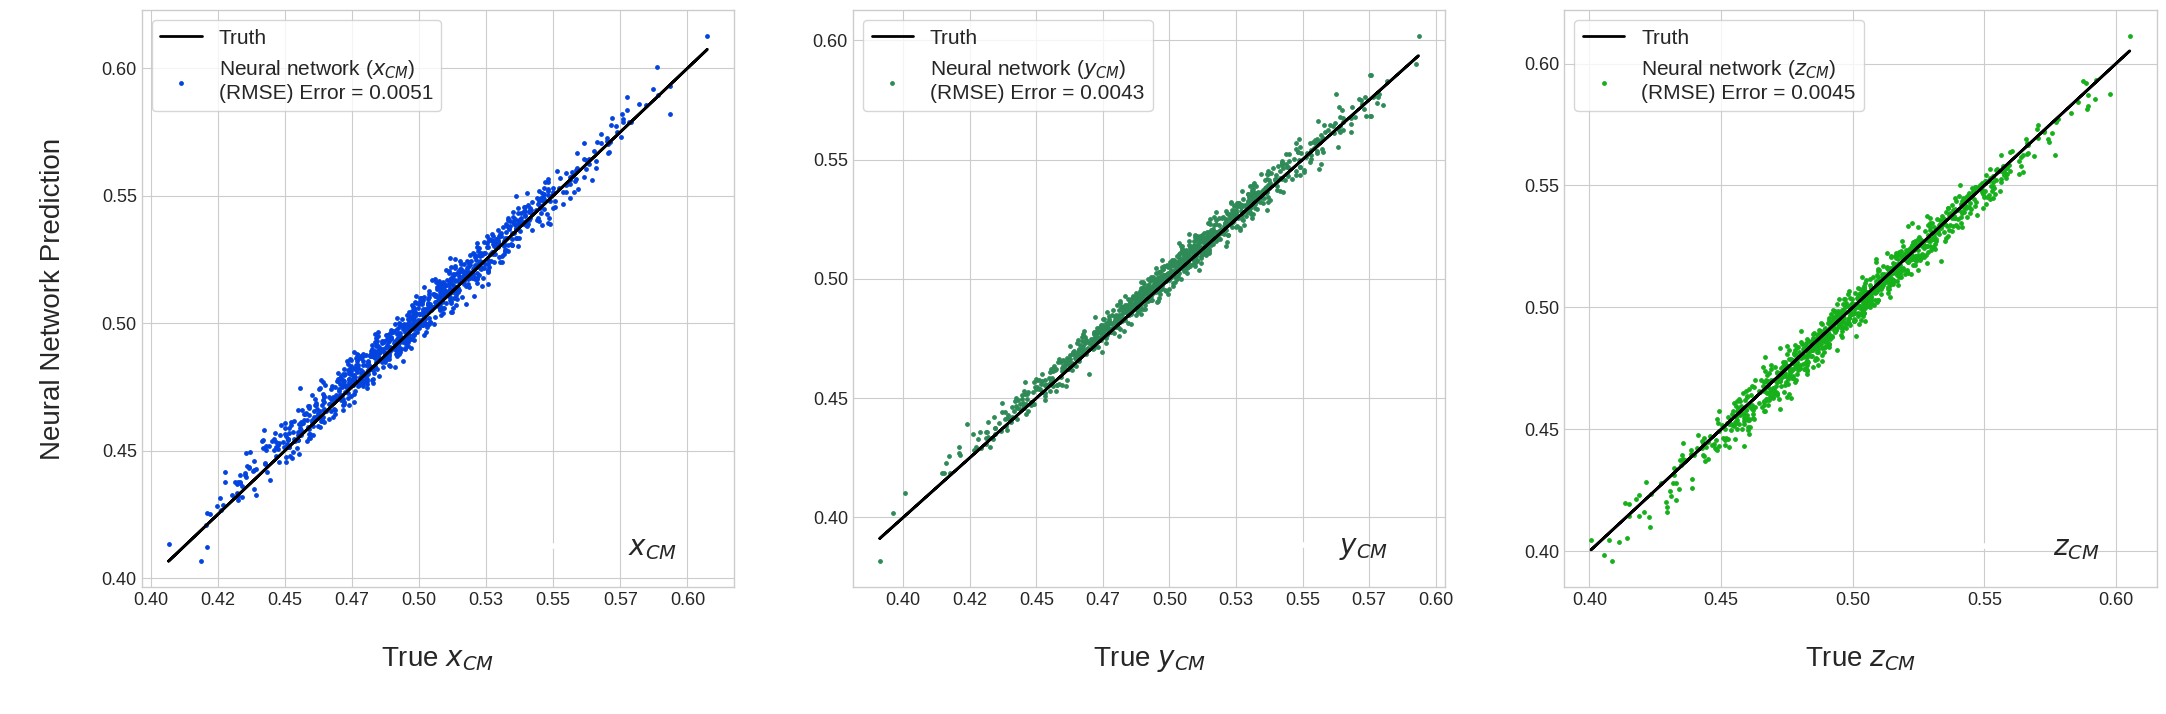

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 3, figsize=(26,7.5))


plt.style.use('default')
plt.style.use('seaborn-whitegrid')


coords = ['x_{CM}','y_{CM}','z_{CM}']

colors = ['xkcd:blue', 'seagreen', 'xkcd:green']

for i in range(3):

    ax[i].plot(params_true_cm[:,i], params_true_cm[:,i], color = 'black', linewidth = 2, label = 'Truth')
    ax[i].scatter(params_true_cm[:,i], params_NN_cm[:,i], s=6, color=colors[i], label = 'Neural network (${}$)\n(RMSE) Error = {:.4f}'.format(coords[i], error[i]))
    ax[i].legend(frameon=True)
    ax[i].set_xlabel('\nTrue ${}$\n'.format(coords[i]), fontsize = 20)
    if i ==0:
        ax[i].set_ylabel('\nNeural Network Prediction\n', fontsize = 20)
    legend_elements1 = [Line2D([0], [0], color='white', lw=4, label= r'${}$     '.format(coords[i]))]
    leg1 = ax[i].legend(handles=legend_elements1, loc = 'lower right', fontsize = 20,frameon = False)
    ax[i].add_artist(leg1)
    ax[i].legend(frameon=True, fontsize = 15)
    ax[i].set_xticklabels(params_true_cm, fontsize= 13)
    ax[i].set_yticklabels(params_NN_cm, fontsize= 13)

    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

